## **Google Drive Connection**

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import zipfile
import shutil

# Base directory on Google Drive
main_directory_path = "/content/drive/MyDrive/CHALLENGE 2"

# Define subdirectories for models, logs, submissions and data
models_dir = os.path.join(main_directory_path, "models")
logs_dir = os.path.join(main_directory_path, "logs")
submission_dir = os.path.join(main_directory_path, "submissions")
data_dir = os.path.join(main_directory_path, "new_data")

# Create directories on Drive if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(submission_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# Paths to compressed train/test archives on Drive
train_compressed_path = os.path.join(data_dir, "new_train_data.zip")
test_compressed_path = os.path.join(data_dir, "new_test_data.zip")

# Path to train labels CSV on Drive
train_labels_path = os.path.join(data_dir, "new_train_labels.csv")

# Local paths for the copied zip files
local_train_zip = "/content/new_train_data.zip"
local_test_zip = "/content/new_test_data.zip"

# Local extraction folders (Colab SSD)
local_train_dir = "/content/data/new_train_data"
local_test_dir = "/content/data/new_test_data"

os.makedirs(local_train_dir, exist_ok=True)
os.makedirs(local_test_dir, exist_ok=True)

# Copy zip archives from Drive to local Colab storage
shutil.copy(train_compressed_path, local_train_zip)
shutil.copy(test_compressed_path, local_test_zip)

# Extract train archive into local train directory
with zipfile.ZipFile(local_train_zip, 'r') as z:
    z.extractall(local_train_dir)

# Extract test archive into local test directory
with zipfile.ZipFile(local_test_zip, 'r') as z:
    z.extractall(local_test_dir)

# Final paths to train/test image folders
train_folder = os.path.join(local_train_dir, "train_data")
test_folder = os.path.join(local_test_dir, "test_data")


## **Libraries Import**

In [ ]:
SEED = 42

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings to keep output clean
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import core Python and scientific modules
import logging
import random
import numpy as np

# Import PyTorch and related utilities
import torch
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import WeightedRandomSampler
import torchvision
from torchvision import models
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

# TensorBoard configuration and model directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

# Select device (GPU if available, otherwise CPU) and configure CuDNN
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other utilities and ML/plotting libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from scipy import stats
import hashlib
import re

# Configure plotting style
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Seed all random number generators for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Strong determinism (slower but more reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

PyTorch version: 2.9.0+cu126
Device: cuda


## **Data Loading**

In [ ]:
# Utility to compute new size and padding coordinates to resize an image/mask to a square canvas while preserving aspect ratio
def compute_resize_params(h, w, target_size=224):
    # Compute scale factor
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Compute coordinates to center the resized image/mask
    y_start = (target_size - new_h) // 2
    x_start = (target_size - new_w) // 2
    y_end = y_start + new_h
    x_end = x_start + new_w

    return new_h, new_w, y_start, y_end, x_start, x_end


# Jointly preprocess an image–mask pair: resize with padding and normalize
def transform_pair(img, mask, target_size=224):
    # Use original image size to compute resize and padding parameters
    h, w = img.shape[:2]
    new_h, new_w, y_start, y_end, x_start, x_end = compute_resize_params(h, w, target_size)

    # Convert image from BGR (OpenCV default) to RGB
    img = img[..., ::-1]

    # Normalize pixel values to [0, 1] as float32
    img = (img / 255).astype(np.float32)

    # Resize image while keeping aspect ratio
    img_resized = cv2.resize(img, (new_w, new_h))

    # Create a square canvas and place the resized image at the center
    img_canvas = np.zeros((target_size, target_size, 3), dtype=img_resized.dtype)
    img_canvas[y_start:y_end, x_start:x_end, :] = img_resized

    # Extract border pixels of the resized image to compute the mode color
    top = img_resized[0, :, :]
    bottom = img_resized[-1, :, :]
    left = img_resized[:, 0, :]
    right = img_resized[:, -1, :]
    border_pixels = np.concatenate([top, bottom, left, right], axis=0)

    # Flatten border pixels and compute per-channel mode
    border_flat = border_pixels.reshape(-1, 3).astype(np.float32)
    mode_r = stats.mode(border_flat[:, 0], keepdims=True)[0][0]
    mode_g = stats.mode(border_flat[:, 1], keepdims=True)[0][0]
    mode_b = stats.mode(border_flat[:, 2], keepdims=True)[0][0]
    border_color = np.array([mode_r, mode_g, mode_b], dtype=img_resized.dtype)

    # Fill padding areas of the image with the border mode color
    if y_start > 0:
        img_canvas[:y_start, :, :] = border_color
    if y_end < target_size:
        img_canvas[y_end:, :, :] = border_color
    if x_start > 0:
        img_canvas[:, :x_start, :] = border_color
    if x_end < target_size:
        img_canvas[:, x_end:, :] = border_color

    # If mask has 3 channels, keep only one (assume grayscale stored as RGB)
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    # Resize mask with nearest-neighbor to preserve label values
    mask_resized = cv2.resize(
        mask, (new_w, new_h),
        interpolation=cv2.INTER_NEAREST
    )

    # Create a square canvas for the mask and place the resized mask at the center
    mask_canvas = np.zeros((target_size, target_size), dtype=np.float32)
    mask_canvas[y_start:y_end, x_start:x_end] = mask_resized.astype(np.float32)
    mask_canvas = mask_canvas / 255.0

    return img_canvas, mask_canvas


# Load all image–mask pairs from a folder, apply preprocessing, and return them as NumPy arrays
def load_data(folder, target_size=224):
    images = []
    masks = []

    # Sort the elements of the folder to align images and masks
    all_files = sorted(os.listdir(folder))
    img_files = sorted([f for f in all_files if f.startswith("img")])
    mask_files = sorted([f for f in all_files if f.startswith("mask")])

    # Read and transform each image–mask pair
    for img_name, mask_name in zip(img_files, mask_files):
        img_path = os.path.join(folder, img_name)
        mask_path = os.path.join(folder, mask_name)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        if img is None or mask is None:
            continue

        # Transform the image–mask pair
        img_t, mask_t = transform_pair(img, mask, target_size=target_size)
        images.append(img_t)
        masks.append(mask_t)

    return np.array(images), np.array(masks)

The training dataset is loaded at low resolution to simplify the cleaning process and reduce memory usage.

In [ ]:
# Load and preprocess all training image–mask pairs at low resolution
train_images, train_masks = load_data(train_folder, target_size=224)
print("Images shape:", train_images.shape)
print("Masks shape:", train_masks.shape)

Images shape: (691, 224, 224, 3)
Masks shape: (691, 224, 224)


The training dataset is composed of 691 image–mask pairs, before the cleaning process.

In [ ]:
# Load training labels from CSV, map class names to integer IDs, and build the ordered list of class names
train_labels = pd.read_csv(train_labels_path)

# Class labels
labels = {
    0: 'Luminal A',
    1: 'Luminal B',
    2: 'HER2(+)',
    3: 'Triple negative',
}

# Convert and reshape labels to column vectors (N, 1) and map to integers
train_labels = train_labels['label'].values
train_labels = train_labels.reshape(-1, 1)
train_labels = np.vectorize({v: k for k, v in labels.items()}.get)(train_labels)

# Extract ordered list of class names
unique_labels = list(labels.values())

## **Data Cleaning**

A careful data cleaning process is crucial to ensure stable training and effective learning from such a small dataset. The first step is to check for duplicate images in the training set.

In [ ]:
def hash_image(arr: np.ndarray) -> str:
    # Make sure the array is stored contiguously in memory and compute SHA-256 hash
    arr_c = np.ascontiguousarray(arr)
    h = hashlib.sha256(arr_c.view(np.uint8)).hexdigest()
    return h

# Detect duplicate images using a SHA-256 hash of the image array
def find_duplicate_image_indices(images):
    seen_hashes = {}
    duplicate_indices = []

    for idx, img in enumerate(images):
        # Compute hash for current image
        h = hash_image(img)

        if h in seen_hashes:
            # Duplicate found: record the index of this duplicate
            duplicate_indices.append(idx)
        else:
            # First time seeing this hash
            seen_hashes[h] = idx

    duplicate_indices = np.array(duplicate_indices, dtype=int)

    return duplicate_indices


# Check for duplicate images in the training set without removing them
duplicate_indices = find_duplicate_image_indices(train_images)

print("Total images:", len(train_images))
print("Detected duplicates:", len(duplicate_indices))


Total images: 691
Detected duplicates: 0


There are no duplicate samples in the training set, so we can proceed to the next cleaning step and remove outliers from the data.

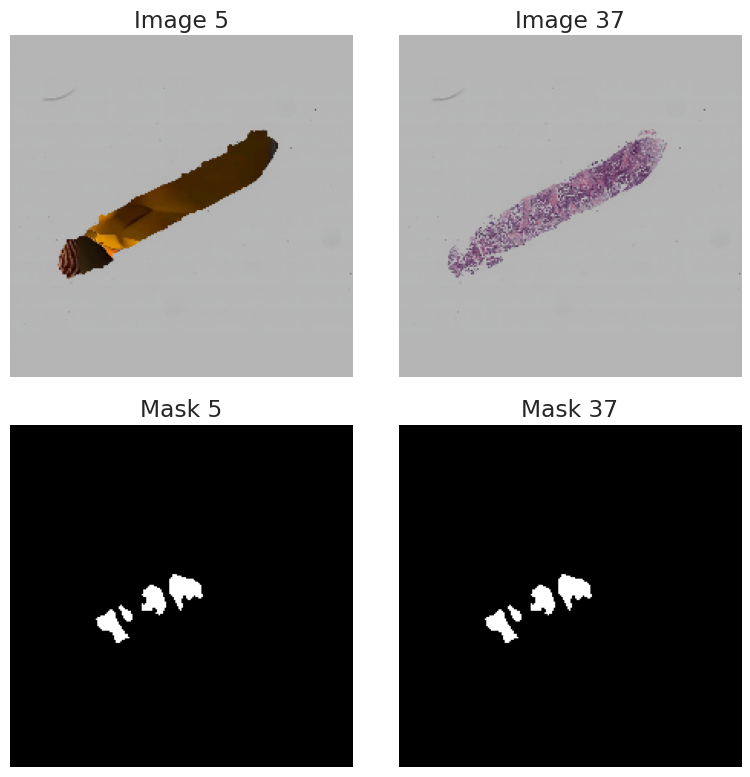

In [ ]:
# Plot two selected images and their corresponding masks
idx1 = 5
idx2 = 37

indices = [idx1, idx2]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for col, idx in enumerate(indices):
    img = train_images[idx]
    mask = train_masks[idx]

    # Top row: images
    axes[0, col].imshow(img)
    axes[0, col].set_title(f"Image {idx}")
    axes[0, col].axis("off")

    # Bottom row: corresponding masks
    axes[1, col].imshow(mask, cmap="gray")
    axes[1, col].set_title(f"Mask {idx}")
    axes[1, col].axis("off")

plt.tight_layout()
plt.show()


The first type of outliers are images showing a normal cell shape with a Shrek image underneath. These outliers are detected by leveraging the masks, since they share the same masks as legitimate cell images.

In [ ]:
# Find the pairs with the same mask
def get_duplicate_mask_groups(masks):

    mask_groups = {}

    # Map each unique hash to the list of indices that share that mask
    for idx, mask in enumerate(masks):
        h = hash_image(mask)
        if h not in mask_groups:
            mask_groups[h] = []
        mask_groups[h].append(idx)

    # Keep only hashes that appear more than once
    dup_mask_groups = [idx_list for idx_list in mask_groups.values() if len(idx_list) > 1]

    num_groups = len(dup_mask_groups)
    num_images_in_groups = sum(len(g) for g in dup_mask_groups)

    print(f"Number of duplicate mask groups: {num_groups}")
    print(f"Total images involved in duplicate masks: {num_images_in_groups}")

    return dup_mask_groups

# Check for duplicate masks in the dataset
dup_mask_groups = get_duplicate_mask_groups(train_masks)

Number of duplicate mask groups: 60
Total images involved in duplicate masks: 120


To separate cells containing the Shrek copy from normal cells, we use their embeddings computed by a pretrained ResNet and perform a distance-based outlier analysis in the embedding space.

In [ ]:
# Pretrained ResNet18 as feature extractor
base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
base_model.fc = nn.Identity()
base_model.to(device)
base_model.eval()

# Transform the images to tensor and normalization
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# Calculate the embedding using the retrained model
def compute_embeddings(images, batch_size=4):

  embs = []
  with torch.no_grad():
    for i, img in enumerate(images):
        x = preprocess(img).float().unsqueeze(0)
        x = x.to(device)
        feat = base_model(x)
        embs.append(feat.cpu())
        del x, feat

    return torch.cat(embs, dim=0)

# Calculate the embeddings for each image in the dataset
embeddings = compute_embeddings(train_images)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


In [ ]:
# Compute the mean embedding and the L2 distance of each sample from this mean
mean_emb = embeddings.mean(dim=0, keepdim=True)
dist_from_mean = torch.norm(embeddings- mean_emb, dim=1)

In [ ]:
# Label for each mask group the farthest embedding as Shrek and the closest as a normal cell and count
labeled_indices = []
labels_binary = []

for group in dup_mask_groups:
    if len(group) < 2:
        continue

    # Distances from the mean embedding for all images sharing the same mask
    group_dists = [(idx, float(dist_from_mean[idx])) for idx in group]
    group_dists_sorted = sorted(group_dists, key=lambda x: x[1], reverse=True)

    shrek_idx, _ = group_dists_sorted[0]
    cell_idx,  _ = group_dists_sorted[-1]

    labeled_indices.append(shrek_idx)
    labels_binary.append(1)

    labeled_indices.append(cell_idx)
    labels_binary.append(0)

print("Labeled samples:", len(labeled_indices))
print("Shrek:", sum(labels_binary))
print("Cells:", len(labels_binary) - sum(labels_binary))


Labeled samples: 120
Shrek: 60
Cells: 60


Once the Shrek images have been separated from their corresponding normal cell shapes, the embeddings of these two groups are used to train a linear classifier in the embedding space. This classifier is then applied to the remaining samples to detect additional Shrek images that do not share a mask with a normal cell, so they can be removed from the dataset.

In [ ]:
# Train a logistic regression classifier to distinguish Shrek images from normal cells using the labeled embeddings
X_labeled = embeddings[labeled_indices].detach().numpy()
y_labeled = np.array(labels_binary)

clf_shrek = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)
clf_shrek.fit(X_labeled, y_labeled)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
# Apply the Shrek classifier to all embeddings and select Shrek candidates using a probability threshold
X_all = embeddings.detach().numpy()
probs_shrek = clf_shrek.predict_proba(X_all)[:, 1]

shrek_threshold = 0.7
shrek_indices = np.where(probs_shrek >= shrek_threshold)[0]
cell_indices  = np.where(probs_shrek <  shrek_threshold)[0]

print("Total images:", len(train_images))
print("Detected Shrek candidates:", len(shrek_indices))

Total images: 691
Detected Shrek candidates: 60


The classifier did not detect any additional Shrek images in the dataset, so every Shrek sample appears to have a duplicate with the same mask. The indices of these images are stored and will be removed at the end of the cleaning process.

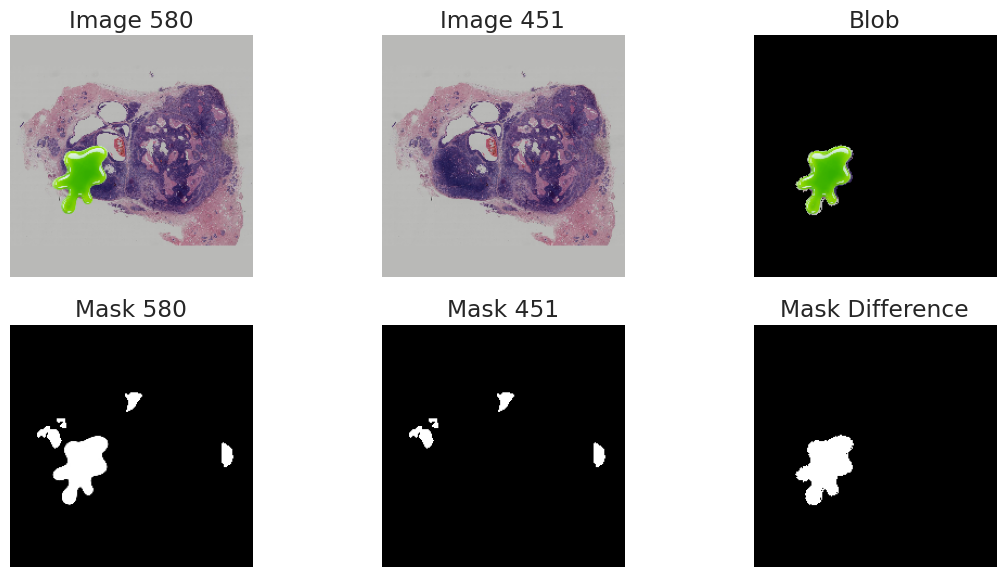

In [ ]:
# Compare two masks and their images and visualize the green blob isolated by the mask difference
i, j = 580, 451

mask_i = train_masks[i]
mask_j = train_masks[j]

diff = (mask_i != mask_j).astype(np.uint8)
mask_blob = diff.astype(bool)

blob = np.zeros_like(train_images[i])
blob[mask_blob] = train_images[i][mask_blob]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

axes[0, 0].imshow(train_images[i])
axes[0, 0].set_title(f"Image {i}")
axes[0, 0].axis("off")

axes[0, 1].imshow(train_images[j])
axes[0, 1].set_title(f"Image {j}")
axes[0, 1].axis("off")

axes[0, 2].imshow(blob)
axes[0, 2].set_title("Blob")
axes[0, 2].axis("off")

axes[1, 0].imshow(mask_i, cmap="gray")
axes[1, 0].set_title(f"Mask {i}")
axes[1, 0].axis("off")

axes[1, 1].imshow(mask_j, cmap="gray")
axes[1, 1].set_title(f"Mask {j}")
axes[1, 1].axis("off")

axes[1, 2].imshow(diff, cmap="gray")
axes[1, 2].set_title("Mask Difference")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


The second type of outliers are images showing a normal cell with a green blob on or near the cell. These outliers are detected using the masks, since the green blob is also present in the mask and can be isolated by computing the bitwise difference between two masks.

In [ ]:
# Compute the fraction of foreground pixels whose color is close to the blob RGB within a tolerance
def compute_blob_score(img, mask, target_rgb, tol=0.1):
    fg = mask > 0.5
    if fg.sum() == 0:
        return 0.0

    diff = img - target_rgb[None, None, :]
    dist = np.linalg.norm(diff, axis=-1)
    blob_like = (dist < tol) & fg

    return blob_like.sum() / fg.sum()


# Estimate the blob reference color from a known blob image.
idx_blob = 580

blob_img = train_images[idx_blob]
blob_mask_img = train_masks[idx_blob] > 0.5

R = blob_img[..., 0][blob_mask_img]
G = blob_img[..., 1][blob_mask_img]
B = blob_img[..., 2][blob_mask_img]

blob_color = np.array([R.mean(), G.mean(), B.mean()])

# Compute the blob score for each image in the dataset.
blob_scores = np.zeros(len(train_images), dtype=np.float32)

for i, (img, m) in enumerate(zip(train_images, train_masks)):
    blob_scores[i] = compute_blob_score(img, m, blob_color, tol=0.15)


In [ ]:
# Find the indices of images with a non-zero blob score
blob_indices = np.where(blob_scores > 0)[0]

print("Total images:", len(train_images))
print("Detected blob candidates:", len(blob_indices))

Total images: 691
Detected blob candidates: 50


In [ ]:
# Convert indices to integer arrays
duplicate_indices = np.array(duplicate_indices, dtype=int)
shrek_indices = np.array(shrek_indices, dtype=int)
blob_indices  = np.array(blob_indices,  dtype=int)

# Union of all indices to drop
to_drop = np.unique(np.concatenate([shrek_indices, blob_indices]))
print("Total images to drop:", len(to_drop))

# Boolean mask to indicate the elements to keep
keep = np.ones(len(train_images), dtype=bool)
keep[to_drop] = False

# Apply the filter to obtain cleaned images, masks, and labels
train_images_clean = train_images[keep]
train_masks_clean  = train_masks[keep]
train_labels_clean = train_labels[keep]

print("Original images:", len(train_images))
print("Cleaned images:", len(train_images_clean))

Total images to drop: 110
Original images: 691
Cleaned images: 581


## **Exploration and Data Analysis**

In [ ]:
# Print the shapes of the loaded dataset
print("Training-Validation Images Shape:", train_images_clean.shape)
print("Training-Validation Masks Shape:", train_masks_clean.shape)
print("Training-Validation Label Shape:", train_labels_clean.shape)

Training-Validation Images Shape: (581, 224, 224, 3)
Training-Validation Masks Shape: (581, 224, 224)
Training-Validation Label Shape: (581, 1)


The cleaned dataset is composed of 581 image-mask pairs. Other types of outliers will be handled implicitly with our tiling methodology.

In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(train_labels_clean, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
1    204
0    158
2    150
3     69
Name: count, dtype: int64


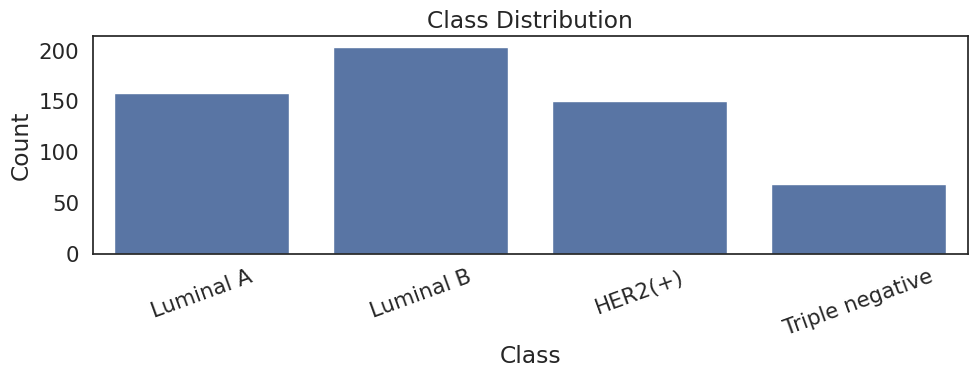

In [ ]:
# Plot the class distribution as a bar chart
class_ids, counts = np.unique(train_labels_clean.flatten(), return_counts=True)
class_names = [labels[cid] for cid in class_ids]

plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


There are four classes in the dataset: Luminal A, Luminal B, HER2(+), and Triple Negative. The first three classes are almost balanced, whereas the Triple Negative class is underrepresented, containing between one third and one half as many samples as each of the other classes. For illustration, we show one example from each class.

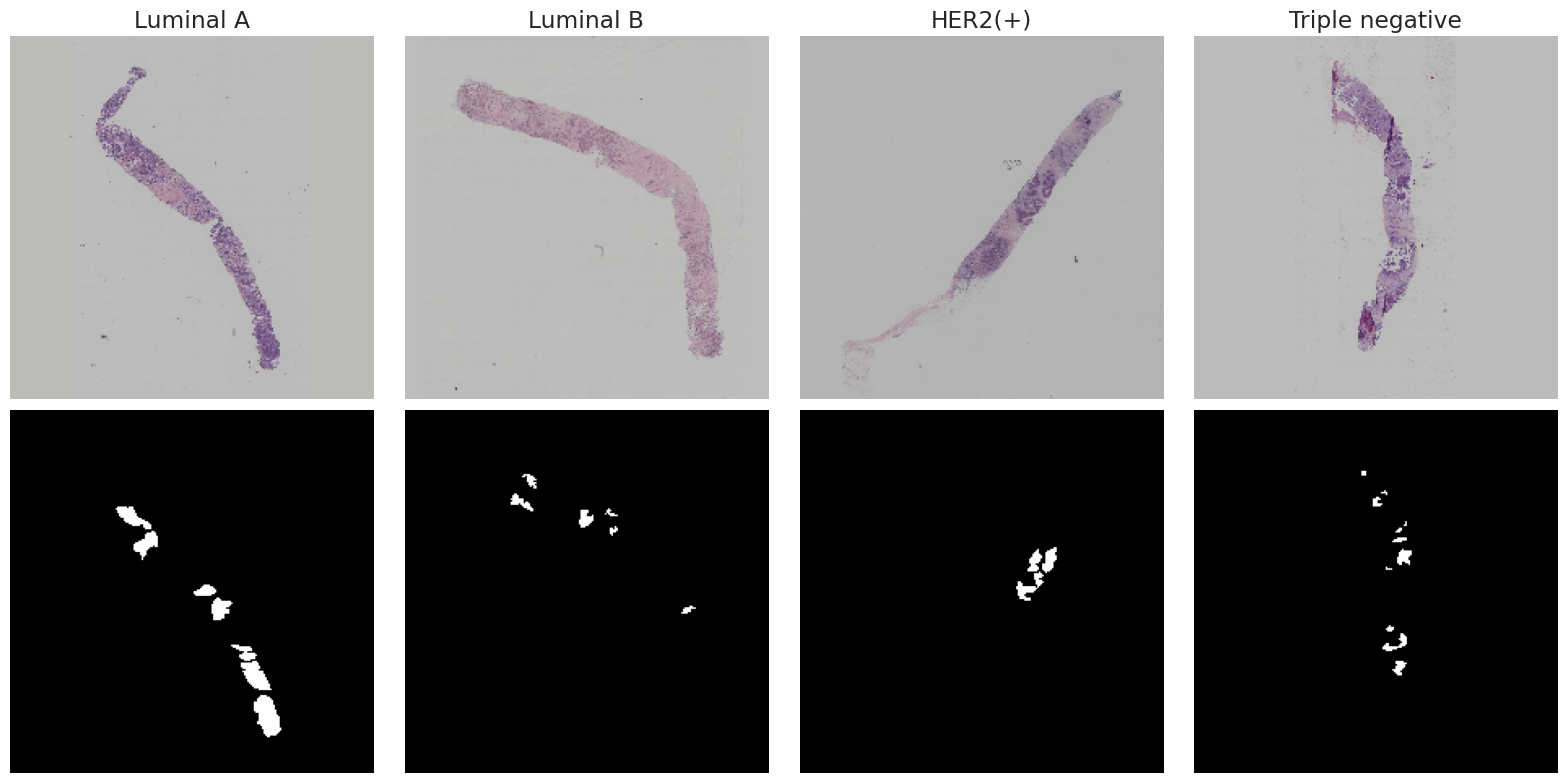

In [ ]:
# Plot one random sample per class in fixed order
ordered_class_ids = [0, 1, 2, 3]
indices = []

for cid in ordered_class_ids:
    class_idxs = np.where(train_labels_clean.flatten() == cid)[0]
    if len(class_idxs) > 0:
        idx = np.random.choice(class_idxs)
        indices.append(idx)

fig, axes = plt.subplots(2, len(indices), figsize=(4 * len(indices), 8))

for i, idx in enumerate(indices):
    img = train_images_clean[idx]
    mask = train_masks_clean[idx]
    label_id = int(train_labels_clean[idx][0])
    label_name = labels[label_id]

    # Images with titles as labels
    axes[0, i].imshow(img)
    axes[0, i].set_title(label_name)
    axes[0, i].axis("off")

    # Corresponding masks
    axes[1, i].imshow(mask, cmap="gray")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


## **Tiles Creation**

Each image is loaded at its native resolution and divided into tiles of fixed size 224×224 pixels. Tiles are then filtered using the segmentation mask, discarding those with no or very few pixels belonging to the region of interest (ROI).

This strategy offers several advantages:
*   Images are not resized to a fixed resolution, preserving fine details and local
*   The size of the dataset is substantially increased, helping to mitigate data scarcity.
*   Noise in the image (e.g., blue markings) and large black areas are removed, as they do not lie within the ROI defined by the mask.






In [ ]:
# Extract image tiles and corresponding mask tiles, keeping only those with sufficient positive mask pixels, and generate a unique name
def extract_tiles_with_names(img, mask, base_name, tile_size=224, stride=224, min_mask_pixels=200):

    H, W, _ = img.shape
    tiles = []
    mask_tiles = []
    names = []

    # Tiles counter for each image
    tile_id = 0

    # Slide a window over the image with the given stride
    for y in range(0, H - tile_size + 1, stride):
        for x in range(0, W - tile_size + 1, stride):

            # Extract image and mask tiles
            tile = img[y:y+tile_size, x:x+tile_size]
            m = mask[y:y+tile_size, x:x+tile_size]

            # Skip tiles with too few positive mask pixels
            if (m > 0).sum() < min_mask_pixels:
                continue

            # Build tile name with zero padding
            tiles.append(tile)
            mask_tiles.append(m)
            names.append(f"{base_name}_t{tile_id:03d}")
            tile_id += 1

    return tiles, mask_tiles, names

In [ ]:
# Load and extracts images and masks froma folder and collect the valid tiles
def load_data_tiles_streaming(folder, to_delete=None, labels=None, tile_size=224, stride=224, min_mask_pixels=200, buffer_size=500):

    # Indices of slides to skip
    to_delete = set(to_delete) if to_delete is not None else set()

    all_files = sorted(os.listdir(folder))
    img_files = sorted([f for f in all_files if f.startswith("img")])
    mask_files = sorted([f for f in all_files if f.startswith("mask")])

    N = len(img_files)

    # Temporary buffers to accumulate tiles before flushing to global storage
    tiles_buf = []
    names_buf = []
    labels_buf = []
    weights_buf = []

    # Global buffers storing all chunks
    tiles_all = []
    names_all = []
    labels_all = []
    weights_all = []

    for idx in range(N):

        # Skip images marked for deletion
        if idx in to_delete:
            continue

        # Load image (convert BGR to RGB and normalize) and its mask
        img = cv2.imread(os.path.join(folder, img_files[idx]))[..., ::-1] / 255.0
        mask = cv2.imread(os.path.join(folder, mask_files[idx]))[:, :, 0]

        base_name = os.path.splitext(img_files[idx])[0]

        # Use slide-level label if provided
        label = int(labels[idx][0]) if labels is not None else None

        # Total foreground pixels in the whole mask
        mask_total_pixels = (mask > 0).sum()
        mask_total_pixels = max(mask_total_pixels, 1)

        # Extract valid tiles and their corresponding mask tiles
        tiles, mask_tiles, names = extract_tiles_with_names(
            img, mask, base_name,
            tile_size=tile_size,
            stride=stride,
            min_mask_pixels=min_mask_pixels
        )

        # Compute a weight for each tile based on its foreground fraction
        for m in mask_tiles:
            tile_pixels = (m > 0).sum()
            w = tile_pixels / mask_total_pixels
            weights_buf.append(w)

        # Add tiles and names to the current buffer
        tiles_buf.extend(tiles)
        names_buf.extend(names)

        # Repeat slide label for each tile, if labels are available
        if labels is not None:
            labels_buf.extend([label] * len(tiles))

        # Flush buffer to global lists when it reaches the specified size
        if len(tiles_buf) >= buffer_size:

            tiles_all.append(np.array(tiles_buf))
            names_all.append(np.array(names_buf))
            weights_all.append(np.array(weights_buf))

            if labels is not None:
                labels_all.append(np.array(labels_buf))

            # Reset temporary buffers
            tiles_buf = []
            names_buf = []
            weights_buf = []
            labels_buf = []

    # Save the last chunk
    if len(tiles_buf) > 0:
        tiles_all.append(np.array(tiles_buf))
        names_all.append(np.array(names_buf))
        weights_all.append(np.array(weights_buf))

        if labels is not None:
            labels_all.append(np.array(labels_buf))

    # Final concatenation over all chunks
    tiles_final = np.concatenate(tiles_all, axis=0)
    names_final = np.concatenate(names_all, axis=0)
    weights_final = np.concatenate(weights_all, axis=0)

    if labels is not None:
        # Output with labels for train set
        labels_final = np.concatenate(labels_all, axis=0)
        return tiles_final, names_final, labels_final, weights_final
    else:
        # Output without labels for test set
        return tiles_final, names_final, weights_final

In [ ]:
# Extract training tiles, their names, slide-level labels, and per-tile weights
tiles_train, names_train, labels_train_tiles, weights_train = load_data_tiles_streaming(folder=train_folder, labels=train_labels, to_delete=to_drop, tile_size=224, stride=224, min_mask_pixels=200, buffer_size=500)

# Inspect shapes to verify
print("Train tiles:", tiles_train.shape)
print("Train labels:", labels_train_tiles.reshape(-1, 1).shape)
print("Train weights:", weights_train.reshape(-1, 1).shape)

Train tiles: (3371, 224, 224, 3)
Train labels: (3371, 1)
Train weights: (3371, 1)


From the 581 cleaned images in the training set, 3371 tiles are extracted, and each tile inherits the label of the image from which it was generated.

In [ ]:
# Extract training tiles, their names and per-tile weights
tiles_test, names_test, weights_test = load_data_tiles_streaming(folder=test_folder, labels=None, to_delete=None, tile_size=224, stride=224, min_mask_pixels=200, buffer_size=500)

# Inspect shapes to verify
print("Test tiles:", tiles_test.shape)
print("Test weights:", weights_test.reshape(-1, 1).shape)

Test tiles: (2707, 224, 224, 3)
Test weights: (2707, 1)


From the 477 images composing the test set, 2707 tiles are extracted, and each tile inherits the label of the image from which it was generated.

In [ ]:
# @title Saving NPZ
# np.savez_compressed(train_tiles_compressed_path, images=tiles_train, names=names_train, labels=labels_train_tiles, weights=weights_train)
# np.savez_compressed(test_tiles_compressed_path, images=tiles_test, names=names_test, weights=weights_test)

Tiles and their associated metadata are stored in a compressed file to streamline subsequent loading and reuse in the training pipeline.

## **Tiles inspection**

In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(labels_train_tiles, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
1    1208
2     895
0     881
3     387
Name: count, dtype: int64


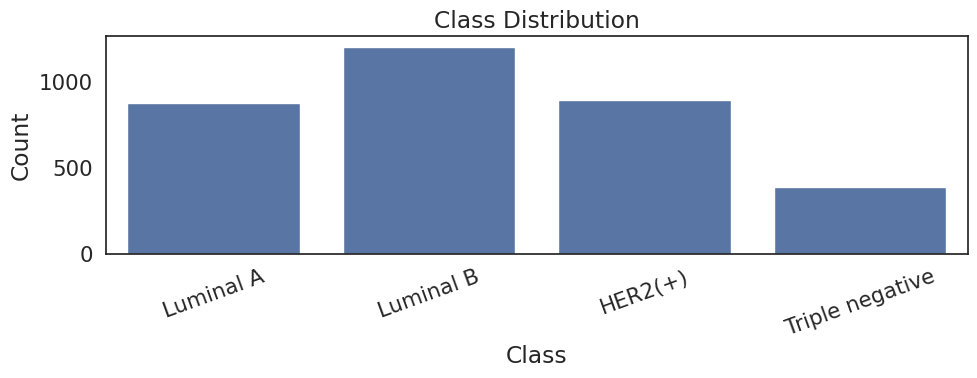

In [ ]:
# Plot the class distribution as a bar chart
class_ids, counts = np.unique(labels_train_tiles.flatten(), return_counts=True)
class_names = [labels[cid] for cid in class_ids]

plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


After the decomposition, the class proportions remain almost unchanged, so the previous considerations about class balance still hold.

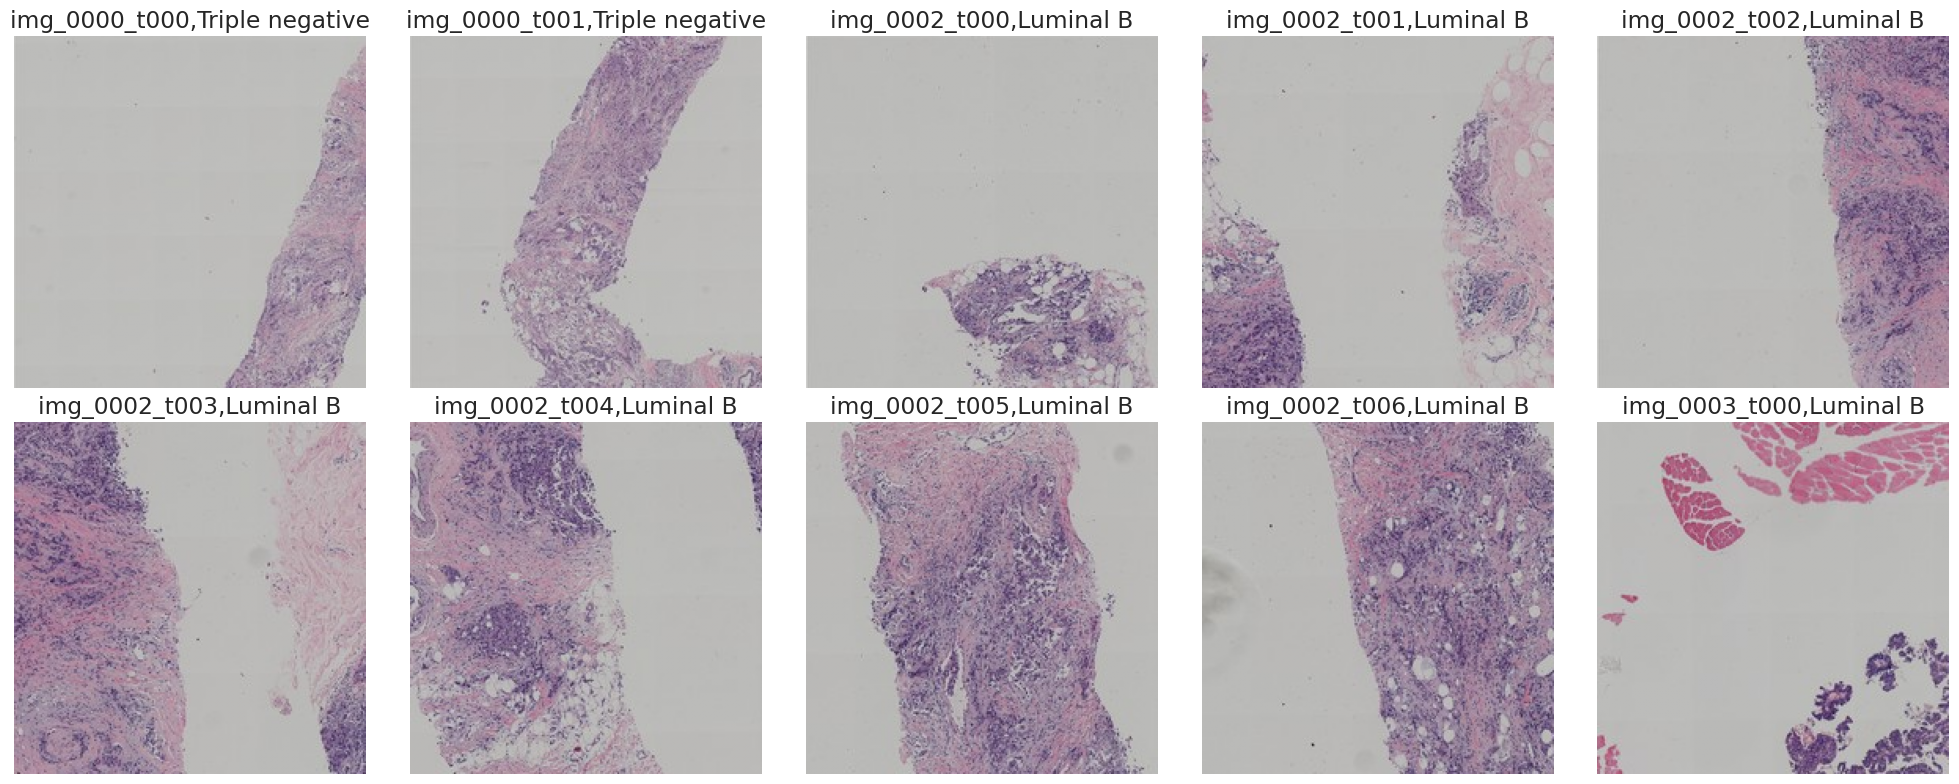

In [ ]:
# Select the first 5 indices
selected_indices = range(5)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for j in range(2):
  for i, idx in enumerate(range(5*j,5*(j+1))):
    # Plot the images
    ax_img = axes[j,i]
    ax_img.imshow(tiles_train[idx], vmin=0., vmax=1.)
    ax_img.set_title(f'{names_train[idx]},{labels[labels_train_tiles[idx]]}')
    ax_img.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()